USING NNs TO CLASSIFY POINT CLOUDS STARTING FROM THEIR PERSISTENT DIAGRAM:

> Generate Train and Test Dataset with certain amounts of point clouds

    > Actual dataset

    > PDs from each sample

> Crete NNs

    > DEEPESET

    > PERSLAY

> Check accuracy of Models, on train and test

In [25]:
import random
import itertools
import functools
import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


import gudhi as gd
import torch
import torch.nn as nn

def rand(shape, low, high):
    """Tensor of random numbers, uniformly distributed on [low, high]."""
    return torch.rand(shape) * (high - low) + low

def count_parameters(model):
    """Return the number of trainable parameters of a model (the total number of scalars)."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## DATASET

In [2]:
# I WANT TO COMPARE POINT WITH 1K POINTS WITH THE SAME STARTING POINT
def generate_orbits(n_points_per_orbit = 1000, params = [2.5, 3.5, 4.0, 4.1, 4.3], same_init_point = True):
    # create point clouds 
    ORBITS = np.zeros([len(params), n_points_per_orbit, 2])
    xcur_0, ycur_0 = np.random.rand(), np.random.rand() # not necesary to save the first one
    for id_pc, param in enumerate(params): # id_point_cloud
        if same_init_point:
            xcur, ycur = xcur_0, ycur_0 # not necesary to save the first one
        else:
            xcur, ycur =np.random.rand(), np.random.rand()
        for id_pt in range(n_points_per_orbit): # id_point
            xcur = (xcur + param * ycur * (1. - ycur)) % 1
            ycur = (ycur + param * xcur * (1. - xcur)) % 1
            ORBITS[id_pc, id_pt, :] = [xcur, ycur]
    return ORBITS

# function from [len(params), n_points, 2] to alpha-complex and persistence diagram
# to create PDs we need to: points -> skeleton(ac) -> simplex(st) -> persistence(pers)
# for each element of the dataset we'll have len(params) PDs to be compared
import gudhi as gd
def extract_PD(cloud, id_class):
    """extract a dict 

    Args:
        cloud (_type_): array [1000,2] composing th ewhole point cloud
        id_class (_type_): index about the class of membership

    Returns:
        dict: with keys ['persist_0','persist_1','id_class']
    """
    # for every point cloud we create a dictionary storing the label and its persistence
    # usage of dictionary to store each other possible data linked to the point clous
    ac = gd.AlphaComplex(points=cloud)
    st = ac.create_simplex_tree()
    pers = st.persistence()
    #? EXTENDED PERSISTENCE?
    #! TRANSPOSE TO HAVE THEN [BATCH SIZE, 2, NUM POINTS]
    pers_0 = np.array(st.persistence_intervals_in_dimension(0)).transpose()#*100
    pers_1 = np.array(st.persistence_intervals_in_dimension(1)).transpose()#*100
    pers_dict = {
        'cloud': cloud, #* UNCOMMENT THE LINE IF YOU WANT TO VISUALIZE POINT CLOUDS LATER
        # 'skeleton': ac, # no more used
        # 'complex': st, # used for bottleneck distance
        'persist_0': pers_0[:,:-1], # removing the last barcode, the one with inf
        'persist_1': pers_1, # here we should never have inf, since [0,1]^2 is compact/bounded  
        # 'persist': pers, # actual PD
        'id_class': id_class # label for classification
    }
    return pers_dict

# def pd_to_tensor(pd, value):
#     # tens_intervals = torch.tensor([list(tp[1]) for tp in pd ])
#     tens_intervals = torch.tensor(pd).float()
#     # this tensor can contain float('inf)
#     tens_intervals[torch.isinf(tens_intervals)] = value
#     return tens_intervals

def preproc_prom(tens, prom):
    diff = tens[1] - tens[0]
    sort_diff = torch.argsort(diff, descending=True)
    sort_tens = tens[:,sort_diff]
    return sort_tens[:,:prom]

In [3]:
### FULL DATA GENERATION 
# (~2 mins) ---------------------------------------

# hyper params
n_points = 1000
params = [2.5, 3.5, 4.0, 4.1, 4.3]
same_init_point = True
n_seq_per_dataset = [700, 300] # I want [i, len(params), n_points, 2]

batch_size = 128
extended_pers = False
k_pd_preproc = 500

# init list fo persistence diagrams
pds_train = []
pds_test = []

# TRAIN 
for i in tqdm(range(n_seq_per_dataset[0]), desc='Create TRAIN Point Clouds'):
    ORBS = generate_orbits(n_points, params, same_init_point) # CREATE THE 5 POINT CLOUDS
    for j in range(ORBS.shape[0]):
        ij_pers = extract_PD(ORBS[j,:,:], j) # EXTRACT PDs
        pds_train.append(ij_pers) # STORE IN THE LIST pds_train

train_batched_data = [] # BATCHING DATA FOR THE NN
batching = len(pds_train)//batch_size
for i in range(batching):
    train_batched_data.append(pds_train[i*batch_size:(i+1)*batch_size])
# check if we have to add the last batch
if batching*batch_size != len(pds_train):
    train_batched_data.append(pds_train[batching*batch_size:])
print(f'{len(train_batched_data) = }\n')
    

# TEST
for i in tqdm(range(n_seq_per_dataset[1]), desc='Create TEST Point Clouds'):
    ORBS = generate_orbits(n_points, params, same_init_point) # CREATE THE 5 POINT CLOUDS
    for j in range(ORBS.shape[0]):
        ij_pers = extract_PD(ORBS[j,:,:], j) # EXTRACT PDs
        pds_test.append(ij_pers) # STORE IN THE LIST pds_test

test_batched_data = [] # BATCHING DATA FOR THE NN
batching = len(pds_test)//batch_size
for i in range(batching):
    test_batched_data.append(pds_test[i*batch_size:(i+1)*batch_size])
# check if we have to add the last batch
if batching*batch_size != len(pds_test):
    test_batched_data.append(pds_test[batching*batch_size:])
print(f'{len(test_batched_data) = }')

Create TRAIN Point Clouds: 100%|██████████| 700/700 [00:35<00:00, 19.76it/s]


len(train_batched_data) = 28



Create TEST Point Clouds: 100%|██████████| 300/300 [00:18<00:00, 16.50it/s]

len(test_batched_data) = 12


In [4]:
# check the order of persistences; BRUTE FORCE: expecting 4 {False}
contains_inf = [ np.any([np.any(np.isinf(lst)) for lst in l['persist_0']]) for l in pds_train ]; print(set(contains_inf))
contains_inf = [ np.any([np.any(np.isinf(lst)) for lst in l['persist_1']]) for l in pds_train ]; print(set(contains_inf))
contains_inf = [ np.any([np.any(np.isinf(lst)) for lst in l['persist_0']]) for l in pds_test ]; print(set(contains_inf))
contains_inf = [ np.any([np.any(np.isinf(lst)) for lst in l['persist_1']]) for l in pds_test ]; print(set(contains_inf))

{False}
{False}
{False}
{False}


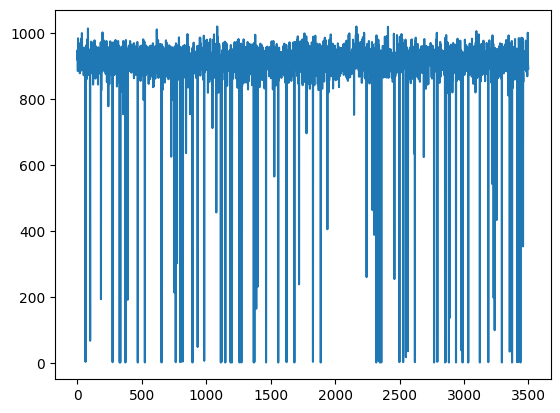

In [5]:
dims = [sample['persist_1'].shape[1] for sample in pds_train]
plt.plot(dims)

In [7]:
level_to_check = [1,100,200,300,400,500,600,700,800,900,1000,1025]
for level in level_to_check:
    print(f'level = {level:^4} => num of barcodes = {len([x for x in dims if x <= level])}')

level =  1   => num of barcodes = 35
level = 100  => num of barcodes = 69
level = 200  => num of barcodes = 77
level = 300  => num of barcodes = 82
level = 400  => num of barcodes = 86
level = 500  => num of barcodes = 91
level = 600  => num of barcodes = 93
level = 700  => num of barcodes = 98
level = 800  => num of barcodes = 105
level = 900  => num of barcodes = 1082
level = 1000 => num of barcodes = 3490
level = 1025 => num of barcodes = 3500


In [18]:
dim_1 = [idx for idx, dim in enumerate(dims) if dim<100]
cl_dim_1 = []
for dim in dim_1:
    point_cloud = pds_train[dim]['cloud']
    class_id = pds_train[dim]['id_class']
    # plt.cla()
    # plt.scatter(point_cloud[:,0], point_cloud[:,1])
    # print(f'\n - {dim} --- {class_id = } -----------')
    # plt.show()
    if class_id not in cl_dim_1:
        cl_dim_1.append(class_id)
cl_dim_1

[3, 4, 0]

-------------------------------------------------------

In [ ]:
params = [2.5, 3.5, 4.0, 4.1, 4.3]
n_points = 1000
same_init_point = True
n_seq_per_dataset = [700, 700] # I want [i, len(params), n_points, 2]

train_dataset = []
test_dataset = []

for i in tqdm(range(n_seq_per_dataset[0]), desc='Create Train Point Clouds'):
    ORB = generate_orbits(n_points, params, same_init_point)
    train_dataset.append(ORB)
train_dataset = np.stack(train_dataset)

for i in tqdm(range(n_seq_per_dataset[1])):
    ORB = generate_orbits(n_points, params, same_init_point)
    test_dataset.append(ORB)
test_dataset = np.stack(test_dataset)

train_dataset.shape, test_dataset.shape

In [ ]:
params = [2.5, 3.5, 4.0, 4.1, 4.3]
n_points = 1000
same_init_point = True
n_seq_per_dataset = [700, 700] # I want [i, len(params), n_points, 2]

train_dataset = []
test_dataset = []

for i in tqdm(range(n_seq_per_dataset[0]), desc='Create Train Point Clouds'):
    ORB = generate_orbits(n_points, params, same_init_point)
    train_dataset.append(ORB)
train_dataset = np.stack(train_dataset)

for i in tqdm(range(n_seq_per_dataset[1])):
    ORB = generate_orbits(n_points, params, same_init_point)
    test_dataset.append(ORB)
test_dataset = np.stack(test_dataset)

train_dataset.shape, test_dataset.shape

Compute PDs for each point cloud, associating it wrt its class' label

In [ ]:
pds_train = []
for i in tqdm(range(train_dataset.shape[0])):
    for j in range(train_dataset.shape[1]):
        ij_pers = extract_PD(train_dataset[i,j,:,:], j)
        pds_train.append(ij_pers)

In [ ]:
pds_test = []
for i in tqdm(range(test_dataset.shape[0])):
    for j in range(test_dataset.shape[1]):
        ij_pers = extract_PD(test_dataset[i,j,:,:], j)
        pds_test.append(ij_pers)

In [ ]:
len(pds_train), len(pds_test) # check dimensions

In [ ]:
import gudhi as gd
im_res = 40
PI = gd.representations.PersistenceImage(bandwidth=1e-4, weight=lambda x: x[1]**2, \
                                         im_range=[0,.004,0,.004], resolution=[im_res,im_res])
                                         
pd_0 = pds_train[1][0]
pd_0_compl = pd_0['complex']
pi = PI.fit_transform([pd_0_compl.persistence_intervals_in_dimension(1)])
plt.imshow(np.flip(np.reshape(pi[0], [im_res,im_res]), 0))
plt.title("Persistence Image")

Trying DEEPSET

HERE THERE IS A PROBLEM: HOW DO WE WANT TO HANDLE THE CHANGING SIZE OF H1?!

A possible solution is transform it in a Pers Image, but we leave the 'only tda' path

## NNs: DEEPSET & PARSLAY

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PermutationEquivariantLayer(nn.Module):
    "PERSLAY LAYER"
    def __init__(self, dimension, perm_op:str, lbda, b, gamma):
        super(PermutationEquivariantLayer, self).__init__()
        self.dimension = dimension
        self.perm_op = perm_op
        self.lbda = lbda
        self.b = b
        self.gamma = gamma

    def forward(self, inp):
        dimension_before, num_pts = inp.shape[2], inp.shape[1]
        b = self.b.unsqueeze(0).unsqueeze(0)
        A = torch.einsum("ijk,kl->ijl", inp, self.lbda).reshape(-1, num_pts, self.dimension)
        if self.perm_op is not None:
            if self.perm_op == "max":
                beta = torch.tile(torch.unsqueeze(torch.max(inp, dim=1)[0], 1), [1, num_pts, 1])
            elif self.perm_op == "min":
                beta = torch.tile(torch.unsqueeze(torch.min(inp, dim=1)[0], 1), [1, num_pts, 1])
            elif self.perm_op == "sum":
                beta = torch.tile(torch.unsqueeze(torch.sum(inp, dim=1), 1), [1, num_pts, 1])
            else:
                raise Exception("perm_op should be min, max or sum")
            B = torch.einsum("ijk,kl->ijl", beta, self.gamma).reshape(-1, num_pts, self.dimension)
            return A - B + b
        else:
            return A + b

class RationalHatLayer(nn.Module):
    "RATIONAL HAT LAYER"
    def __init__(self, q, mu, r):
        super(RationalHatLayer, self).__init__()
        self.q = q
        self.mu = mu
        self.r = r

    def forward(self, inp):
        mu, r = self.mu.unsqueeze(0).unsqueeze(0), self.r.unsqueeze(0).unsqueeze(0)
        dimension_before, num_pts = inp.shape[2], inp.shape[1]
        bc_inp = inp.unsqueeze(-1)
        norms = torch.norm(bc_inp - mu, p=self.q, dim=2)
        return 1 / (1 + norms) - 1 / (1 + torch.abs(torch.abs(r) - norms))

class RationalLayer(nn.Module):
    def __init__(self, mu, sg, al):
        super(RationalLayer, self).__init__()
        self.mu = mu
        self.sg = sg
        self.al = al

    def forward(self, inp):
        mu, sg, al = self.mu.unsqueeze(0).unsqueeze(0), self.sg.unsqueeze(0).unsqueeze(0), self.al.unsqueeze(0).unsqueeze(0)
        dimension_before, num_pts = inp.shape[2], inp.shape[1]
        bc_inp = inp.unsqueeze(-1)
        return 1 / torch.pow(1 + torch.sum(torch.abs(bc_inp - mu) * torch.abs(sg), dim=2), al)

class ExponentialLayer(nn.Module):
    def __init__(self, mu, sg):
        super(ExponentialLayer, self).__init__()
        self.mu = mu
        self.sg = sg

    def forward(self, inp):
        mu, sg = self.mu.unsqueeze(0).unsqueeze(0), self.sg.unsqueeze(0).unsqueeze(0)
        dimension_before, num_pts = inp.shape[2], inp.shape[1]
        bc_inp = inp.unsqueeze(-1)
        return torch.exp(torch.sum(-torch.square(bc_inp - mu) * torch.square(sg), dim=2))

class LandscapeLayer(nn.Module):
    def __init__(self, sp):
        super(LandscapeLayer, self).__init__()
        self.sp = sp

    def forward(self, inp):
        sp = self.sp.unsqueeze(0).unsqueeze(0)
        return torch.maximum(.5 * (inp[:, :, 1:2] - inp[:, :, 0:1]) - torch.abs(sp - .5 * (inp[:, :, 1:2] + inp[:, :, 0:1])), torch.tensor([0.]))


class BettiLayer(nn.Module):
    def __init__(self, theta, sp):
        super(BettiLayer, self).__init__()
        self.theta = theta
        self.sp = sp

    def forward(self, inp):
        sp = self.sp.unsqueeze(0).unsqueeze(0)
        X, Y = inp[:, :, 0:1], inp[:, :, 1:2]
        return 1. / (1. + torch.exp(-self.theta * (.5 * (Y - X) - torch.abs(sp - .5 * (Y + X)))))


class EntropyLayer(nn.Module):
    def __init__(self, theta, sp):
        super(EntropyLayer, self).__init__()
        self.theta = theta
        self.sp = sp

    def forward(self, inp):
        sp = self.sp.unsqueeze(0).unsqueeze(0)
        bp_inp = torch.einsum("ijk,kl->ijl", inp, torch.tensor([[1., -1.], [0., 1.]]))
        L, X, Y = bp_inp[:, :, 1:2], bp_inp[:, :, 0:1], bp_inp[:, :, 0:1] + bp_inp[:, :, 1:2]
        LN = L * (1. / torch.unsqueeze(torch.matmul(L[:, :, 0], torch.ones([L.shape[1], 1])), -1))
        entropy_terms = torch.where(LN > 0., -LN * torch.log(LN), LN)
        return entropy_terms * (1. / (1. + torch.exp(-self.theta * (.5 * (Y - X) - torch.abs(sp - .5 * (Y + X))))))


class ImageLayer(nn.Module):
    def __init__(self, image_size, image_bnds, sg):
        super(ImageLayer, self).__init__()
        self.image_size = image_size
        self.image_bnds = image_bnds
        self.sg = sg

    def forward(self, inp):
        bp_inp = torch.einsum("ijk,kl->ijl", inp, torch.tensor([[1., -1.], [0., 1.]]))
        dimension_before, num_pts = inp.shape[2], inp.shape[1]
        coords = [torch.arange(start=self.image_bnds[i][0], end=self.image_bnds[i][1], step=(self.image_bnds[i][1] - self.image_bnds[i][0]) / self.image_size[i]) for i in range(dimension_before)]
        M = torch.meshgrid(*coords)
        mu = torch.cat([torch.unsqueeze(tens, 0) for tens in M], dim=0)
        bc_inp = bp_inp.view(-1, num_pts, dimension_before, 1)
        return torch.unsqueeze(torch.exp(torch.sum(-torch.square(bc_inp - mu) / (2 * torch.square(self.sg)), dim=2)) / (2 * np.pi * torch.square(self.sg)), -1)


> DEEPSET NETWORK

In [43]:
class DeepSetLayer(nn.Module):
    """
    DeepSetLayer(in_blocks, out_blocks) takes shape (batch, in_blocks, n) to (batch, out_blocks, n).
    Each block of n scalars is treated as the S_n permutation representation, and maps between blocks are
    S_n-equivariant.
    """
    def __init__(self, in_blocks, out_blocks):
        super().__init__()
        
        self.in_blocks = in_blocks
        self.out_blocks = out_blocks
        
        # Initialisation tactic copied from nn.Linear in PyTorch
        lim = (in_blocks)**-0.5 / 2

        # Alpha corresponds to the identity, beta to the all-ones matrix, and gamma to the additive bias.
        self.alpha = torch.nn.Parameter(data=rand((out_blocks, in_blocks), -lim, lim))
        self.beta = torch.nn.Parameter(data=rand((out_blocks, in_blocks), -lim, lim))
        self.gamma = torch.nn.Parameter(data=rand((out_blocks), -lim, lim))
    
    def forward(self, x):
        # x has shape (batch, in_blocks, n)
        return (
            torch.einsum('...jz, ij -> ...iz', x, self.alpha)
            + torch.einsum('...jz, ij -> ...iz', x.max(axis=-1)[0][..., None], self.beta)
            + self.gamma[..., None]
        )

# Test if we got our tensor nonsense right. For a batch size of 6, and n = 7,
# a DeepSetLayer(2, 3) should map shape (6, 2, 7) to (6, 3, 7).
DeepSetLayer(2, 3)(torch.rand((6, 2, 7))).shape

torch.Size([6, 3, 7])

> EXTRACT AN INVARIANT

In [41]:
class DeepSetSum(nn.Module):
    """
    DeepSetSum(blocks) takes a deep set layer of shape (batch, blocks, n) to a regular layer
    of shape (batch, blocks) by projecting to the trivial representation and then extracting
    a coordinate, eg
        (1, 2, 3, 4) => project to trivial => (2.5, 2.5, 2.5, 2.5) => extract component => 2.5
    """
    def __init__(self, blocks):
        super().__init__()
        
        lim = (blocks)**-0.5 / 2
        self.weight = torch.nn.Parameter(data=rand(blocks, -lim, lim))
        self.bias = torch.nn.Parameter(data=rand(blocks, -lim, lim))
    
    def forward(self, x):
        return x.sum(dim=-1) * self.weight + self.bias
  
# Check shapes. A DeepSetSum(3) should take shape (batch, 3, n) to (batch, 3)
DeepSetSum(5)(torch.rand((6, 5, 7)))[0]

tensor([-0.0991,  0.0681, -0.9168, -0.2258,  0.4504],
       grad_fn=<SelectBackward0>)

In [63]:
l = torch.tensor(batch_in_pd1[0]*1).T
tops, top_idxs = torch.topk(l[:,1]-l[:,0],25,dim=0)
l[top_idxs,:]

tensor([[0.0502, 0.3259],
        [0.0918, 0.3669],
        [0.0559, 0.2800],
        [0.2241, 0.4390],
        [0.0758, 0.2743],
        [0.0411, 0.2047],
        [0.0480, 0.2080],
        [0.0727, 0.2318],
        [0.0545, 0.2057],
        [0.0376, 0.1887],
        [0.0401, 0.1900],
        [0.0489, 0.1919],
        [0.0546, 0.1948],
        [0.1101, 0.2470],
        [0.2591, 0.3868],
        [0.0392, 0.1669],
        [0.0464, 0.1722],
        [0.0501, 0.1729],
        [0.0435, 0.1624],
        [0.0398, 0.1577],
        [0.0474, 0.1645],
        [0.0444, 0.1601],
        [0.0649, 0.1788],
        [0.0549, 0.1647],
        [0.0560, 0.1639]], dtype=torch.float64)

## DEEPSET NETWORK

> DEEP SET NETWORK

In [44]:
# Model structure. Note that we don't specify the input size anywhere!!!
class Perslay_KTH(nn.Module):
    def __init__(self, hidden_size:int = 10, alpha_0:bool = True, alpha_1:bool = True, prom:int = 500, top_k:int = 5, using_len_p1:bool = False):
        super().__init__()
        self.a0 = alpha_0
        self.a1 = alpha_1
        self.prom = prom
        self.top_k = top_k
        self.num_classes = 5
        self.using_len_p1 = using_len_p1

        self.ds_0_a = DeepSetLayer(2,25)
        self.relu_0 = torch.nn.ReLU()
        self.ds_0_b = DeepSetLayer(25,hidden_size)
        # self.ds_0_c = DeepSetLayer(10,5)

        self.ds_1_a = DeepSetLayer(2,25)
        self.relu_1 = torch.nn.ReLU()
        self.ds_1_b = DeepSetLayer(25,hidden_size)
        # self.ds_1_c = DeepSetLayer(10,5)

        if using_len_p1:
            self.linear_dim_H1 = nn.Linear(1,self.top_k)
            self.linear_labels = nn.Linear(self.top_k*(hidden_size*2+1), self.num_classes)
        else:
            self.linear_labels = nn.Linear(self.top_k*(hidden_size*2), self.num_classes)
        


    def forward(self, batch_pers_0, batch_pers_1):
        labels = False
        for p0, p1 in zip(batch_pers_0, batch_pers_1):# one PD at the time due to different cardinality betweeen different H1 barcodes
            # I want to select the self.prom longest barcodes
            p0 = torch.tensor(p0)*100 #? rescsaling
            p0 = preproc_prom(p0, self.prom)
            p0 = self.ds_0_a(p0.float())
            p0 = self.ds_0_b(p0)
            p0, _ = torch.topk(p0, self.top_k, dim=1)

            # same for p1
            p1 = torch.tensor(p1)*100 # not always with same len of p0

            p1_shape = p1.shape[1] # number of elemnts in H1 persistence
            if p1_shape<self.top_k:
                dim_to_add = self.top_k - p1_shape
                aux_zeros = torch.zeros(p1.size(0), dim_to_add)
                p1 = torch.cat((p1, aux_zeros), dim=1)


            p1 = preproc_prom(p1, self.prom)
            p1 = self.ds_1_a(p1.float())
            p1 = self.ds_1_b(p1)
            try:
                p1, _ = torch.topk(p1, self.top_k, dim=1)
            except RuntimeError:
                raise ValueError('')
            
            if self.using_len_p1 == True:
                emb_len = self.linear_dim_H1(torch.tensor([p1_shape]).float())
                concat = torch.cat((p0.view(-1), p1.view(-1), emb_len.view(-1)))
            else:
                concat = torch.cat((p0.view(-1), p1.view(-1)))

            labs = self.linear_labels(concat).unsqueeze(0)

            if isinstance(labels,bool):
                labels = labs
            else:
                labels = torch.cat((labels, labs), dim = 0)
                
        return labels

In [45]:
def test_model(model, test_data, if_plot):
    # Set the model to evaluation mode
    model.eval()

    target_labs = np.array([])
    pred_labs = np.array([])
    correct = 0
    total = 0

    # Disable gradient calculation
    with torch.no_grad():
        # for batch in tqdm(test_data):
        for batch in test_data:
            batch_in_pd0 = [sample['persist_0'] for sample in batch] # get tersor of persistence
            batch_in_pd1 = [sample['persist_1'] for sample in batch] # get tersor of persistence
            batch_target = torch.tensor([sample['id_class'] for sample in batch]) # get target labels

            # Forward pass
            outputs = model(batch_in_pd0, batch_in_pd1)
            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Total number of labels
            total += batch_target.size(0)
            # Total correct predictions
            correct += (predicted == batch_target).sum().item()
            target_labs = np.append(target_labs, predicted)
            pred_labs = np.append(pred_labs, batch_target)

    # Calculate accuracy
    accuracy = 100 * correct / total
    # print('Accuracy on the test set: {:.2f}%'.format(accuracy))

    if if_plot:
        cm = confusion_matrix(np.array(target_labs), np.array(pred_labs))
        classes = [1,2,3,4,5]
        # Plot confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('TEST Confusion Matrix')
        plt.show()
        
    return accuracy

In [46]:
import random
from torch.optim.lr_scheduler import StepLR


model = Perslay_KTH(hidden_size = 25)

# Learning rate and loss function.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# scheduler = StepLR(optimizer, step_size=70, gamma=0.7)
loss_function = nn.CrossEntropyLoss()
epochs = 300
recorded_loss = torch.zeros(epochs)

best_acc = 0.0 

for epoch in range(epochs):
    model.train()

    total_loss = 0.0
    # for batch in tqdm(train_batched_data):
    for batch in train_batched_data:

        batch_in_pd0 = [sample['persist_0'] for sample in batch] # get tersor of persistence

        batch_in_pd1 = [sample['persist_1'] for sample in batch] # get tersor of persistence

        batch_target = torch.tensor([sample['id_class'] for sample in batch]) # get target labels
        # print(f'\n{len(batch_in_pd0) = }\n{len(batch_in_pd1) = }\n{batch_target.shape = }')

        optimizer.zero_grad()
        result = model(batch_in_pd0, batch_in_pd1)
        loss = loss_function(result, batch_target)
        total_loss += float(loss)
        loss.backward()
        optimizer.step()
        # scheduler.step()
    
    recorded_loss[epoch] = total_loss
    print(f"Epoch {epoch+1}/{epochs}, loss {total_loss}")

    test_acc = test_model(model, test_batched_data, if_plot=False)
    if best_acc < test_acc:
        if test_acc > 70.0:
            torch.save(model.state_dict(), f'./Perslay_models/try_acc_{test_acc}.pth')
        print(f'--> IMPROVEMENT from {best_acc} to {test_acc}')
        best_acc = test_acc
    else:
        print(f'> Test Accuracy = {test_acc} [best = {best_acc}]')

fig, ax = plt.subplots()
ax.plot(recorded_loss)
#ax.set_ylim([0, 1])
plt.show()
print(f"Final loss is {recorded_loss[-1]}")

Epoch 1/300, loss 27.963971495628357
--> IMPROVEMENT from 0.0 to 73.53333333333333
Epoch 2/300, loss 21.609690368175507
> Test Accuracy = 72.53333333333333 [best = 73.53333333333333]
Epoch 3/300, loss 19.85062962770462
--> IMPROVEMENT from 73.53333333333333 to 76.13333333333334
Epoch 4/300, loss 19.1639501452446
--> IMPROVEMENT from 76.13333333333334 to 79.2
Epoch 5/300, loss 18.901320338249207
> Test Accuracy = 75.26666666666667 [best = 79.2]
Epoch 6/300, loss 18.497240841388702
--> IMPROVEMENT from 79.2 to 79.53333333333333
Epoch 7/300, loss 17.554348170757294
--> IMPROVEMENT from 79.53333333333333 to 82.06666666666666
Epoch 8/300, loss 16.545835465192795
--> IMPROVEMENT from 82.06666666666666 to 83.0
Epoch 9/300, loss 15.348822623491287
--> IMPROVEMENT from 83.0 to 83.73333333333333
Epoch 10/300, loss 14.271816074848175
--> IMPROVEMENT from 83.73333333333333 to 84.06666666666666
Epoch 11/300, loss 13.446727007627487
--> IMPROVEMENT from 84.06666666666666 to 84.93333333333334
Epoch 1

KeyboardInterrupt: 

In [160]:
torch.save(model.state_dict(), './Perslay_models/try0.pth')

In [ ]:
# Assuming you have a model named 'model' and a test dataloader named 'test_loader'
test_model(model, train_batched_data, if_plot=True)
test_model(model, test_batched_data, if_plot=True)


In [ ]:
import random
from torch.optim.lr_scheduler import StepLR

# Learning rate and loss function.
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# ema_model = torch.optim.swa_utils.AveragedModel(model, \
#             multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(0.))
# scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
loss_function = nn.CrossEntropyLoss()
epochs = 3
recorded_loss = torch.zeros(epochs)

fig, ax = plt.subplots()
ax.plot(recorded_loss)
#ax.set_ylim([0, 1])
plt.show()
print(f"Final loss is {recorded_loss[-1]}")

# Assuming you have a model named 'model' and a test dataloader named 'test_loader'
pred_train, true_train = test_model(model, pds_train)
pred_test, true_test = test_model(model, pds_test)

cm = confusion_matrix(true_train, pred_train)
classes = [1,2,3,4,5]
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('TRAIN Confusion Matrix')
plt.show()

plt.cla()
cm = confusion_matrix(true_test, pred_test)
classes = [1,2,3,4,5]
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('TEST Confusion Matrix')
plt.show()